# Face recognition InsightFace

In [18]:
%load_ext autoreload
%autoreload 2

# put system imports here
import os
import sys
from os.path import join
from glob import glob
from pathlib import Path
import random
import time

# put pip/conda installed imports here
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import imutils
import cv2 as cv
import matplotlib.pyplot as plt

# put local imports here
fp_app_root = join(Path(os.getcwd()).parent)
sys.path.append(fp_app_root)
from app.settings import app_cfg
from app.utils import file_utils, draw_utils, im_utils
from app.models.bbox import BBoxNorm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'
import mxnet
import insightface
from sklearn.metrics.pairwise import cosine_similarity


## Get face image

In [21]:
# download from https://generated.photos/
fp_dir_gan = join(app_cfg.DIR_IMAGES, 'janez_janzas')
fps_im = glob(join(fp_dir_gan, '*.jpg'))
print(len(fps_im))

9


In [22]:
fa = insightface.app.FaceAnalysis()

In [23]:
fa.prepare(-1)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [24]:
fps_vector = []
face_vectors = []

for fp_im in tqdm(fps_im):
  im = cv.imread(fp_im)
  im = imutils.resize(im, width=360)
  face = fa.get(im)
  if len(face):
    face = face[0]
    face_vectors.append(face.normed_embedding)
    fps_vector.append(fp_im)

## Query Image

In [27]:
fp_im = join(app_cfg.DIR_IMAGES, 'Janez_Jansa_id-card_01.jpg')
im_query = cv.imread(fp_im)
face_query = fa.get(im_query)[0]
vector_query = face_query.normed_embedding

In [28]:
n_results = 3
st = time.time()
sim = cosine_similarity([vector_query], face_vectors)[0]
print(time.time() - st)

0.00043892860412597656


In [35]:
match_idxs = np.argpartition(sim, -n_results)[-n_results:]
match_idxs = match_idxs[np.argsort(sim[match_idxs])]
match_idxs = match_idxs[::-1]

print(match_idxs)
for i in match_idxs:
  if sim[i] > 0.5:
    print(f'Found match! --> {Path(fps_vector[i]).name}')
  print(sim[i])

[6 2 1]
Found match! --> 300868340_640_2.jpg
0.90389144
0.10304267
0.085627824


In [30]:
#ims_match = [fp_im_hanks]
ims_match = [im_query] + [cv.imread(fps_vector[i]) for i in match_idxs]

In [31]:
montages = imutils.build_montages(ims_match, (400,400), (4,2))

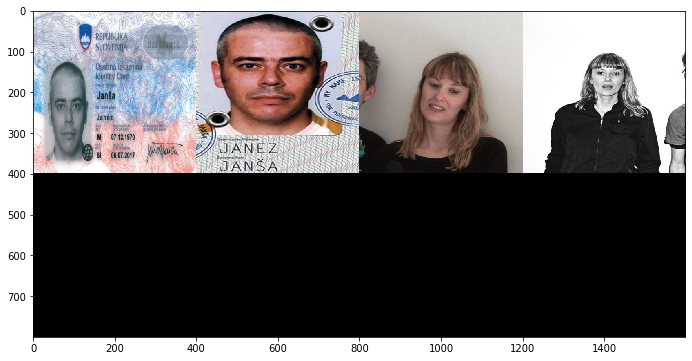

In [32]:
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(montages[0], cv.COLOR_BGR2RGB))